<a href="https://colab.research.google.com/github/matheusbarroso/image_processing_with_python/blob/master/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hands-On Image Processing with Python](https://www.packtpub.com/big-data-and-business-intelligence/hands-image-processing-python) 
[Matheus de Vasoncellos Barroso](https://github.com/matheusbarroso/image_processing_with_python) Solutions - 11/07/2020
## Chapter 4: Image Enhancement
Questions:
### 1. Implement histogram matching for colored RGB images.





In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow
from skimage.exposure import cumulative_distribution
from skimage import img_as_ubyte

In [2]:
lena_url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
lena = imread(lena_url)

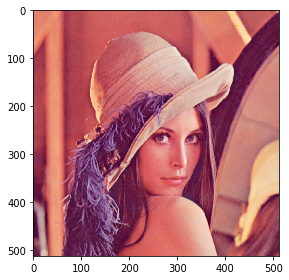

In [3]:
imshow(lena)

In [4]:
leopard_url = 'https://s01.sgp1.cdn.digitaloceanspaces.com/article/143116-bbjrhjihgb-1592568414.jpg'
leop = imread(leopard_url)

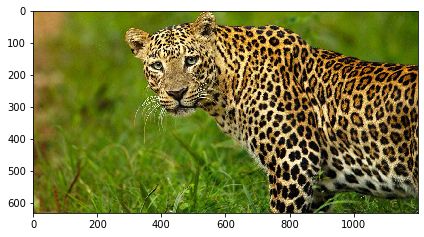

In [5]:
imshow(leop)

We can plot the histogram for each channel:

''

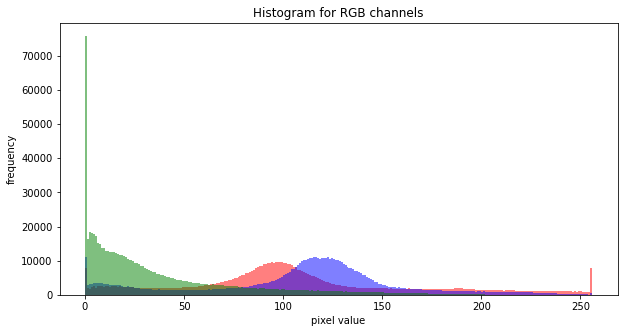

In [6]:
plt.figure(figsize=(10,5))
plt.hist(img_as_ubyte(leop[:, :, 0]).ravel(), color='red', bins = 256, range=(0,256), alpha=0.5)
plt.hist(img_as_ubyte(leop[:, :, 1]).ravel(), color='blue', bins = 256, range=(0,256), alpha=0.5)
plt.hist(img_as_ubyte(leop[:, :, 2]).ravel(), color='green', bins = 256, range=(0,256), alpha=0.5)
plt.ylabel('frequency')
plt.xlabel('pixel value')
plt.title('Histogram for RGB channels')
;

Now we can make usage of the functions in the textbook for computing the matching:

In [7]:
def cdf(im):
  '''Computes the CDF of an image as a 2D numpy ndarray

  Parameters
  ----------
  im : image to compute the cdf
  '''
  c, b = cumulative_distribution(im)
  # pad the begining and ending pixels and their CDF values
  c = np.insert(c, 0, [0]*b[0])
  c = np.append(c, [1]*(255-b[-1]))
  return c

def hist_matching(c, c_t, im):
  '''Computes the histogram matching of two CDF's and an image

  Parameters
  ----------
  c : CDF of input image computed with the function cdf()
  c_t : CDF of template image computed with the function cdf() 
  im : input image as 2D numpy array

  Returns
  -------
  im : returns the modified pixel values fo the input image
'''
  pixels = np.arange(256)
  # find closest pixel-matches corresponding to the CDF of the input image, 
  # given the value of the CDF h of the template image at the corresponding
  # pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
  new_pixels = np.interp(c, c_t, pixels)
  im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
  return im

# now some new functions to compute the matching for RGB channels

def get_channels_list(im):
  '''Returns a list with RGB channels for an image im

  Parameters
  ----------
  im : 3D numpy.ndarray input image
  '''
  return [im[:, :, i] for i in range(3)]

def hist_matching_rgb(input_im, target_im):
  '''Returns the histogram matching image from a target image

  Parameters
  ----------
  input_im : 3D numpy.ndarray input image for histogram matching
  target_im : 3D numpy.ndarray target image for histogram matching
  '''
  input_channel = get_channels_list(input_im)
  target_channel = get_channels_list(target_im)
  input_cdf = map(cdf, input_channel)
  target_cdf = map(cdf, target_channel)
  cdfs = [hist_matching(i, j, input_channel[k]) for k, (i, j) in enumerate(zip(input_cdf, target_cdf))]
  matched_im = np.stack(cdfs, axis=2)
  return matched_im

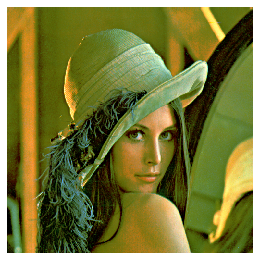

In [8]:
imshow(hist_matching_rgb(lena, leop))
plt.axis('off');

### 2. Use the `equalize()` function from `skimage.filters.rank` to implement local histogram equalization and compare it with the global histogram equalization from `skimage.exposure` with a grayscale image

In [9]:
from skimage.filters.rank import equalize
from skimage.exposure import equalize_hist
from skimage.color import rgb2gray

In [10]:
lena_gray  = rgb2gray(lena)

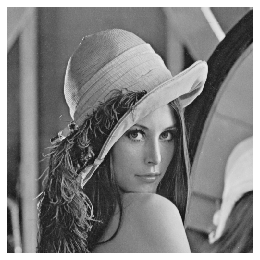

In [11]:
imshow(lena_gray)
plt.axis('off');

In [12]:
img_eq_global = equalize_hist(lena_gray)

In [13]:
img_eq_local = equalize(lena_gray, np.ones(lena_gray.shape))

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


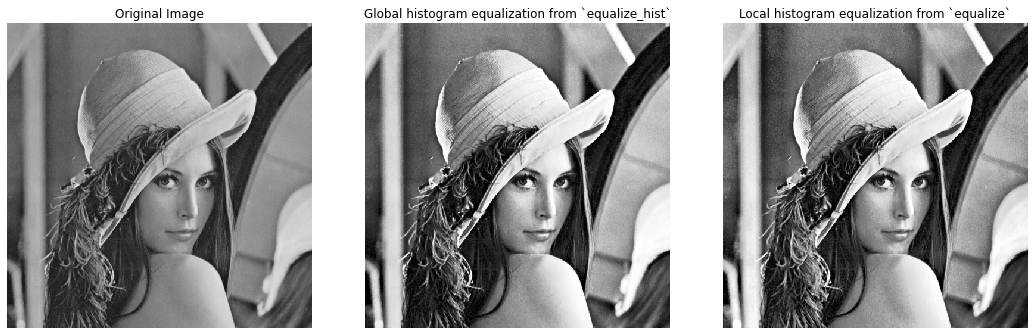

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
imshow(lena_gray)
plt.title('Original Image')
plt.axis('off');

plt.subplot(132)
imshow(img_eq_global)
plt.title('Global histogram equalization from `equalize_hist`')
plt.axis('off');

plt.subplot(133)
imshow(img_eq_local)
plt.title('Local histogram equalization from `equalize`')
plt.axis('off');

### 3. Implement Floyd-Steinberg error-diffusion dithering using the algorithm described here https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering and convert a grayscale image into a binary image.

In [15]:
lena_gray = lena.mean(axis=2).astype(np.uint8)

Adding independent random noise to the Lena image:

In [16]:
lena_noise = np.clip(lena_gray + np.random.uniform(0, 128, (lena_gray.shape)), 0, 255)

''

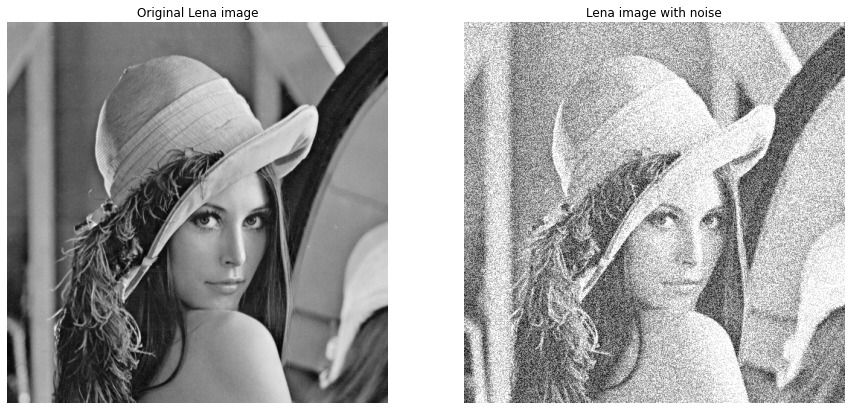

In [17]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.imshow(lena_gray, cmap='gray');
plt.axis('off')
plt.title('Original Lena image');

plt.subplot(122)
plt.imshow(lena_noise, cmap='gray')
plt.axis('off')
plt.title('Lena image with noise')
;

Here follows the pseudocode for the algorithm:

In [18]:
# for each y from top to bottom do
#     for each x from left to right do
#         oldpixel := pixel[x][y]
#         newpixel := find_closest_palette_color(oldpixel)
#         pixel[x][y] := newpixel
#         quant_error := oldpixel - newpixel
#         pixel[x + 1][y    ] := pixel[x + 1][y    ] + quant_error × 7 / 16
#         pixel[x - 1][y + 1] := pixel[x - 1][y + 1] + quant_error × 3 / 16
#         pixel[x    ][y + 1] := pixel[x    ][y + 1] + quant_error × 5 / 16
#         pixel[x + 1][y + 1] := pixel[x + 1][y + 1] + quant_error × 1 / 16

Now let us write a function toe compute the Floyd-Steinberg dithering algorithm:


In [19]:
from itertools import product

In [20]:
def find_closest_palette_color(oldpixel):
    return int(round(oldpixel / 255)*255)

def floyd_steinberg(im):
  '''Function to perform Floyd-Steinberg dithering with error diffusion

  Parameters
  ----------
  im : numpy array with grayscale image on a 252 scale

  Returns
  -------
  pixel: the transformed image
  '''
  pixel = np.copy(im)
  for x, y in product(range(im.shape[0]), range(im.shape[1])):
    oldpixel = pixel[x][y]
    newpixel = find_closest_palette_color(oldpixel)
    pixel[x][y] = newpixel
    quant_error = oldpixel - newpixel
    pixel[x + 1][y] = pixel[x + 1][y] + quant_error * 7 / 16
    pixel[x - 1][y + 1] = pixel[x - 1][y + 1] + quant_error * 3 / 16
    pixel[x][y + 1] = pixel[x][y + 1] + quant_error * 5 / 16
    pixel[x + 1][y + 1] = pixel[x + 1][y + 1] + quant_error * 1 / 16    
    return pixel


''

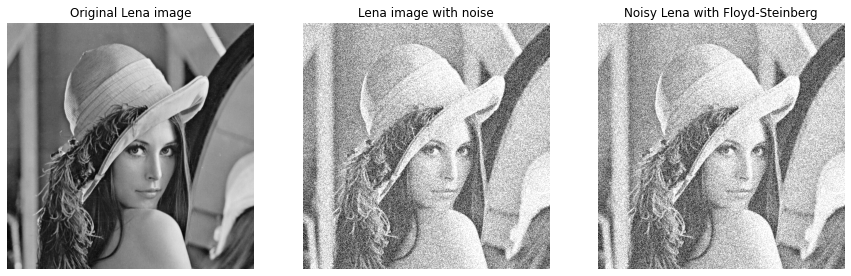

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(131)
plt.imshow(lena_gray, cmap='gray');
plt.axis('off')
plt.title('Original Lena image');

plt.subplot(132)
plt.imshow(lena_noise, cmap='gray')
plt.axis('off')
plt.title('Lena image with noise')

plt.subplot(133)
plt.imshow(floyd_steinberg(lena_noise), cmap='gray')
plt.axis('off')
plt.title('Noisy Lena with Floyd-Steinberg')
;

### 4. Use `ModelFilter()` from PIL for linear smoothing with an image. When is it useful?

In [22]:
from PIL.ImageFilter import ModeFilter
from PIL import Image
from io import BytesIO
import requests

In [23]:
response = requests.get(lena_url)
lena = Image.open(BytesIO(response.content))

In [24]:
lena_gray = lena.convert('RGB').convert('L')

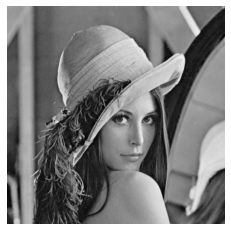

In [25]:
plt.imshow(lena_gray, cmap='gray')
plt.axis('off');

In [26]:
mode_lena_gray = lena_gray.filter(ModeFilter(10))
mode_lena = lena.filter(ModeFilter(10))

''

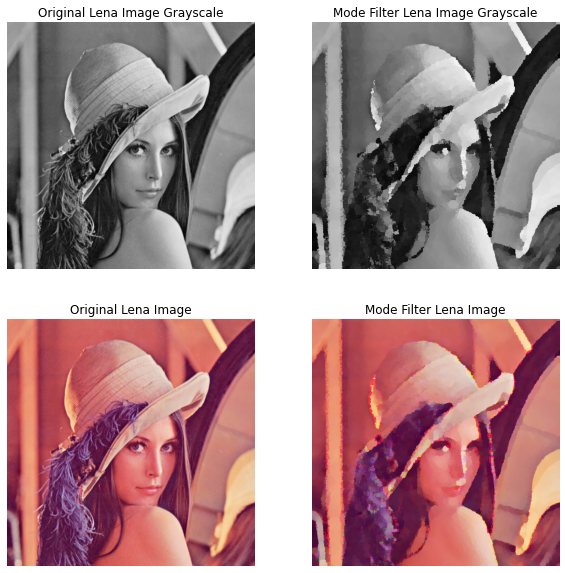

In [27]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(lena_gray, cmap='gray')
plt.axis('off')
plt.title('Original Lena Image Grayscale')


plt.subplot(222)
plt.imshow(mode_lena_gray, cmap='gray')
plt.axis('off')
plt.title('Mode Filter Lena Image Grayscale')

plt.subplot(223)
plt.imshow(lena, cmap='gray')
plt.axis('off')
plt.title('Original Lena Image')


plt.subplot(224)
plt.imshow(mode_lena, cmap='gray')
plt.axis('off')
plt.title('Mode Filter Lena Image')
;

I suppose the mode filter is useful smoothing the image.


### 5. Show an image that can be recovered from a few noisy images otained by adding random Gaussian noise to the original image by simply taking the average of the noisy images. Does taking the median also work?

In [31]:
lena = imread(lena_url)
lena_gray = lena.mean(axis=2).astype(np.uint8)

In [28]:
def salt_pepper_noise(im, noise_proportion=0.3):
  '''Adds salt and pepper noise to an image

  Parameters
  ----------
  im : 3D np.array with RGB image or 2D np.array with grayscale image in the 255
   scale
  '''
  img = np.copy(im)
  w, h = img.shape[:2]
  n = int(w * h * noise_proportion)
  x, y = np.random.randint(0, w, n), np.random.randint(0, h, n)

  for x, y in zip(x,y):
    if im.ndim == 3:
      img[x][y] = np.zeros(3) if np.random.rand() < 0.5 else np.ones(3) * 255
    else:
      img[x][y] = 0 if np.random.rand() < 0.5 else 255
  return img

def gaussian_noise(im, mu=50, sigma=20):
  noise = np.clip(im + np.random.normal(mu, sigma, size=im.shape), 0, 255)
  return noise.astype(np.uint8)
 

def gaussian_enhancing(im, nsamples=10):
  return np.stack([gaussian_noise(im) for _ in range(nsamples)], axis=2)

In [32]:
np.random.seed(123)
lena_sp = salt_pepper_noise(lena_gray, .1)

''

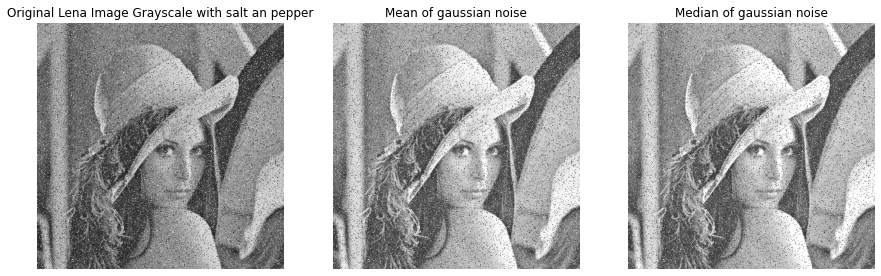

In [33]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(lena_sp, cmap='gray')
plt.axis('off')
plt.title('Original Lena Image Grayscale with salt an pepper')

plt.subplot(132)
plt.imshow(gaussian_enhancing(lena_sp, 100).mean(axis=2), cmap='gray')
plt.axis('off')
plt.title('Mean of gaussian noise')

plt.subplot(133)
plt.imshow(np.median(gaussian_enhancing(lena_sp, 100), axis=2), cmap='gray')
plt.axis('off')
plt.title('Median of gaussian noise')
;